Lambda School Data Science

*Unit 2, Sprint 1, Module 3*

---

# Ridge Regression
- Do one-hot encoding of categorical features
- Do univariate feature selection
- Use scikit-learn to fit Ridge Regression models

### Setup

You can work locally (follow the [local setup instructions](https://lambdaschool.github.io/ds/unit2/local/)) or on Colab (run the code cell below).

Libraries:
- category_encoders
- matplotlib
- numpy
- pandas
- scikit-learn

In [0]:
%%capture
import sys

# If you're on Colab:
if 'google.colab' in sys.modules:
    DATA_PATH = 'https://raw.githubusercontent.com/LambdaSchool/DS-Unit-2-Applied-Modeling/master/data/'
    !pip install category_encoders==2.*

# If you're working locally:
else:
    DATA_PATH = '../data/'

# Do one-hot encoding of categorical features

## Overview

First, let's load the NYC apartment rental listing data:

In [0]:
import numpy as np
import pandas as pd

# Read New York City apartment rental listing data
df = pd.read_csv(DATA_PATH+'apartments/renthop-nyc.csv')
assert df.shape == (49352, 34)

# Remove the most extreme 1% prices,
# the most extreme .1% latitudes, &
# the most extreme .1% longitudes
df = df[(df['price'] >= np.percentile(df['price'], 0.5)) & 
        (df['price'] <= np.percentile(df['price'], 99.5)) & 
        (df['latitude'] >= np.percentile(df['latitude'], 0.05)) & 
        (df['latitude'] < np.percentile(df['latitude'], 99.95)) &
        (df['longitude'] >= np.percentile(df['longitude'], 0.05)) & 
        (df['longitude'] <= np.percentile(df['longitude'], 99.95))]

# Do train/test split
# Use data from April & May 2016 to train
# Use data from June 2016 to test
df['created'] = pd.to_datetime(df['created'], infer_datetime_format=True)
cutoff = pd.to_datetime('2016-06-01')
train = df[df.created < cutoff]
test  = df[df.created >= cutoff]

In [0]:
train.head()

,bathrooms,bedrooms,created,description,display_address,latitude,longitude,price,street_address,interest_level,elevator,cats_allowed,hardwood_floors,dogs_allowed,doorman,dishwasher,no_fee,laundry_in_building,fitness_center,pre-war,laundry_in_unit,roof_deck,outdoor_space,dining_room,high_speed_internet,balcony,swimming_pool,new_construction,terrace,exclusive,loft,garden_patio,wheelchair_access,common_outdoor_space
2,1.0,1,2016-04-17 03:26:41,"Top Top West Village location, beautiful Pre-w...",W 13 Street,40.7388,-74.0018,2850,241 W 13 Street,high,0,0,1,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,1.0,1,2016-04-18 02:22:02,Building Amenities - Garage - Garden - fitness...,East 49th Street,40.7539,-73.9677,3275,333 East 49th Street,low,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,1.0,4,2016-04-28 01:32:41,Beautifully renovated 3 bedroom flex 4 bedroom...,West 143rd Street,40.8241,-73.9493,3350,500 West 143rd Street,low,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0
5,2.0,4,2016-04-19 04:24:47,,West 18th Street,40.7429,-74.0028,7995,350 West 18th Street,medium,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
6,1.0,2,2016-04-27 03:19:56,Stunning unit with a great location and lots o...,West 107th Street,40.8012,-73.9660,3600,210 West 107th Street,low,0,1,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


Some columns are numeric:

In [0]:
# TODO
train.describe()

,bathrooms,bedrooms,latitude,longitude,price,elevator,cats_allowed,hardwood_floors,dogs_allowed,doorman,dishwasher,no_fee,laundry_in_building,fitness_center,pre-war,laundry_in_unit,roof_deck,outdoor_space,dining_room,high_speed_internet,balcony,swimming_pool,new_construction,terrace,exclusive,loft,garden_patio,wheelchair_access,common_outdoor_space
count,31844.000000,31844.000000,31844.000000,31844.000000,31844.000000,31844.000000,31844.000000,31844.000000,31844.000000,31844.000000,31844.000000,31844.000000,31844.000000,31844.000000,31844.000000,31844.000000,31844.000000,31844.000000,31844.000000,31844.000000,31844.000000,31844.000000,31844.000000,31844.000000,31844.000000,31844.000000,31844.000000,31844.000000,31844.000000
mean,1.203728,1.528357,40.750743,-73.972867,3575.604007,0.530430,0.477139,0.480907,0.445861,0.430725,0.418666,0.369834,0.057311,0.267586,0.185938,0.175700,0.133777,0.143983,0.104290,0.088620,0.060734,0.055929,0.051470,0.047733,0.042269,0.044216,0.039222,0.028388,0.029048
std,0.472447,1.105061,0.038658,0.028910,1762.136694,0.499081,0.499485,0.499643,0.497068,0.495185,0.493348,0.482767,0.232439,0.442707,0.389062,0.380571,0.340418,0.351078,0.305641,0.284198,0.238845,0.229788,0.220957,0.213203,0.201204,0.205577,0.194127,0.166082,0.167943
min,0.000000,0.000000,40.575700,-74.087300,1375.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,1.000000,1.000000,40.728500,-73.991800,2500.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,1.000000,1.000000,40.751700,-73.978100,3150.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,1.000000,2.000000,40.773600,-73.955000,4095.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,10.000000,7.000000,40.910200,-73.700100,15500.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


Some columns are _not_ numeric:

In [0]:
# TODO
train.select_dtypes(include='number').describe()

,bathrooms,bedrooms,latitude,longitude,price,elevator,cats_allowed,hardwood_floors,dogs_allowed,doorman,dishwasher,no_fee,laundry_in_building,fitness_center,pre-war,laundry_in_unit,roof_deck,outdoor_space,dining_room,high_speed_internet,balcony,swimming_pool,new_construction,terrace,exclusive,loft,garden_patio,wheelchair_access,common_outdoor_space
count,31844.000000,31844.000000,31844.000000,31844.000000,31844.000000,31844.000000,31844.000000,31844.000000,31844.000000,31844.000000,31844.000000,31844.000000,31844.000000,31844.000000,31844.000000,31844.000000,31844.000000,31844.000000,31844.000000,31844.000000,31844.000000,31844.000000,31844.000000,31844.000000,31844.000000,31844.000000,31844.000000,31844.000000,31844.000000
mean,1.203728,1.528357,40.750743,-73.972867,3575.604007,0.530430,0.477139,0.480907,0.445861,0.430725,0.418666,0.369834,0.057311,0.267586,0.185938,0.175700,0.133777,0.143983,0.104290,0.088620,0.060734,0.055929,0.051470,0.047733,0.042269,0.044216,0.039222,0.028388,0.029048
std,0.472447,1.105061,0.038658,0.028910,1762.136694,0.499081,0.499485,0.499643,0.497068,0.495185,0.493348,0.482767,0.232439,0.442707,0.389062,0.380571,0.340418,0.351078,0.305641,0.284198,0.238845,0.229788,0.220957,0.213203,0.201204,0.205577,0.194127,0.166082,0.167943
min,0.000000,0.000000,40.575700,-74.087300,1375.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,1.000000,1.000000,40.728500,-73.991800,2500.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,1.000000,1.000000,40.751700,-73.978100,3150.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,1.000000,2.000000,40.773600,-73.955000,4095.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,10.000000,7.000000,40.910200,-73.700100,15500.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [0]:
train.describe(exclude='number')

,created,description,display_address,street_address,interest_level
count,31844,30875,31775,31838,31844
unique,31436,25735,6468,11280,3
top,2016-05-14 01:11:03,,Broadway,505 West 37th Street,low
freq,3,906,273,120,22053
first,2016-04-01 22:12:41,NaN,NaN,NaN,NaN
last,2016-05-31 23:10:48,NaN,NaN,NaN,NaN


Let's look at the relationship between `interest_level` and `price`:

In [0]:
# TODO
train['interest_level'].unique()

array(['high', 'low', 'medium'], dtype=object)

In [0]:
train['interest_level'].value_counts()

low       22053
medium     7381
high       2410
Name: interest_level, dtype: int64

In [0]:
train.groupby('interest_level')['price'].mean()

interest_level
high      2728.689212
low       3802.227633
medium    3175.026013
Name: price, dtype: float64

In [0]:
train.groupby('interest_level')['price'].describe()

,count,mean,std,min,25%,50%,75%,max
interest_level,,,,,,,,
high,2410.0,2728.689212,1125.654965,1375.0,1900.0,2450.0,3200.0,11000.0
low,22053.0,3802.227633,1910.469337,1375.0,2600.0,3300.0,4384.0,15500.0
medium,7381.0,3175.026013,1236.912369,1375.0,2300.0,2895.0,3695.0,14000.0


Interest Level seems like a useful, predictive feature. But it's a string — and our scikit-learn models expect all inputs to be numbers. 

So, we can "one-hot encode" the feature.

To go from this:

| interest_level |
|----------------|
| high           |
| medium         |
| low            |


To this:

| interest_level_high | interest_level_medium | interest_level_low |
|---------------------|-----------------------|--------------------|
| 1                   | 0                     | 0                  |
| 0                   | 1                     | 0                  |
| 0                   | 0                     | 1                  |

"One-hot encoding" adds a dimension for each unique value of each categorical feature. So, it may not be a good choice for "high cardinality" categoricals that have dozens, hundreds, or thousands of unique values. 

[Cardinality](https://simple.wikipedia.org/wiki/Cardinality) means the number of unique values that a feature has:
> In mathematics, the cardinality of a set means the number of its elements. For example, the set A = {2, 4, 6} contains 3 elements, and therefore A has a cardinality of 3. 

## Follow Along

The other non-numeric columns have high cardinality. So let's exclude them from our features for now.

In [0]:
# TODO

target = 'price'
high_cardinality = ['display_address', 'street_address', 'description', 'created']
features = train.columns.drop([target] + high_cardinality)
features

Index(['bathrooms', 'bedrooms', 'latitude', 'longitude', 'interest_level',
       'elevator', 'cats_allowed', 'hardwood_floors', 'dogs_allowed',
       'doorman', 'dishwasher', 'no_fee', 'laundry_in_building',
       'fitness_center', 'pre-war', 'laundry_in_unit', 'roof_deck',
       'outdoor_space', 'dining_room', 'high_speed_internet', 'balcony',
       'swimming_pool', 'new_construction', 'terrace', 'exclusive', 'loft',
       'garden_patio', 'wheelchair_access', 'common_outdoor_space'],
      dtype='object')

Here's what `X_train` looks like **before** encoding:

In [0]:
# TODO
X_train = train[features]
y_train = train[target]
X_test = test[features]
y_test = test[target]

In [0]:
X_train.head()

,bathrooms,bedrooms,latitude,longitude,interest_level,elevator,cats_allowed,hardwood_floors,dogs_allowed,doorman,dishwasher,no_fee,laundry_in_building,fitness_center,pre-war,laundry_in_unit,roof_deck,outdoor_space,dining_room,high_speed_internet,balcony,swimming_pool,new_construction,terrace,exclusive,loft,garden_patio,wheelchair_access,common_outdoor_space
2,1.0,1,40.7388,-74.0018,high,0,0,1,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,1.0,1,40.7539,-73.9677,low,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,1.0,4,40.8241,-73.9493,low,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0
5,2.0,4,40.7429,-74.0028,medium,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
6,1.0,2,40.8012,-73.9660,low,0,1,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


Use [OneHotEncoder](https://contrib.scikit-learn.org/categorical-encoding/onehot.html) from the [category_encoders](https://github.com/scikit-learn-contrib/categorical-encoding) library to encode any non-numeric features. (In this case, it's just `interest_level`.)

- Use the **`fit_transform`** method on the **train** set
- Use the **`transform`** method on **validation / test** sets

In [0]:
# TODO
import category_encoders as ce 

encoder = ce.one_hot.OneHotEncoder(use_cat_names=True)
X_train_enc = encoder.fit_transform(X_train)
X_test_enc = encoder.transform(X_test)

Here's what it looks like **after:**

In [0]:
# TODO
X_test_enc.head()

,bathrooms,bedrooms,latitude,longitude,interest_level_high,interest_level_low,interest_level_medium,elevator,cats_allowed,hardwood_floors,dogs_allowed,doorman,dishwasher,no_fee,laundry_in_building,fitness_center,pre-war,laundry_in_unit,roof_deck,outdoor_space,dining_room,high_speed_internet,balcony,swimming_pool,new_construction,terrace,exclusive,loft,garden_patio,wheelchair_access,common_outdoor_space
0,1.5,3,40.7145,-73.9425,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,1.0,2,40.7947,-73.9667,0,1,0,1,1,0,1,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
11,1.0,1,40.8448,-73.9396,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
14,1.0,1,40.7584,-73.9648,0,1,0,1,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
24,2.0,4,40.7391,-73.9936,0,0,1,1,1,1,1,1,1,0,0,1,0,0,0,1,0,1,1,0,0,1,0,0,0,0,0


## Challenge

In your assignment, you will do one-hot encoding of categorical features with feasible cardinality, using the category_encoders library.

# Do univariate feature selection

## Overview

The previous assignment quoted Wikipedia on [Feature Engineering](https://en.wikipedia.org/wiki/Feature_engineering):

> "Some machine learning projects succeed and some fail. What makes the difference? Easily the most important factor is the features used." — Pedro Domingos, ["A Few Useful Things to Know about Machine Learning"](https://homes.cs.washington.edu/~pedrod/papers/cacm12.pdf)

> "Coming up with features is difficult, time-consuming, requires expert knowledge. 'Applied machine learning' is basically feature engineering." — Andrew Ng, [Machine Learning and AI via Brain simulations](https://forum.stanford.edu/events/2011/2011slides/plenary/2011plenaryNg.pdf) 

> Feature engineering is the process of using domain knowledge of the data to create features that make machine learning algorithms work. 

Pedro Domingos says, "the most important factor is the **features used**."

This includes not just **Feature Engineering** (making new features, representing features in new ways) but also **Feature Selection** (choosing which features to include and which to exclude).

There are _many_ specific tools and techniques for feature selection.

- Today we'll try [scikit-learn's `SelectKBest` transformer](https://scikit-learn.org/stable/modules/feature_selection.html#univariate-feature-selection), for "univariate, forward selection."
- Later we'll try another technique, ["permutation importance"](https://www.kaggle.com/dansbecker/permutation-importance)
- If you want to explore even more options, here are some good resources!
  - [scikit-learn's User Guide for Feature Selection](https://scikit-learn.org/stable/modules/feature_selection.html)
  - [mlxtend](http://rasbt.github.io/mlxtend/) library
  - scikit-learn-contrib libraries: [boruta_py](https://github.com/scikit-learn-contrib/boruta_py) & [stability-selection](https://github.com/scikit-learn-contrib/stability-selection)
  - [_Feature Engineering and Selection_](http://www.feat.engineering/) by Kuhn & Johnson.


My general recommendation is:

> Predictive accuracy on test sets is the criterion for how good the model is. — Leo Breiman, ["Statistical Modeling: The Two Cultures"](https://projecteuclid.org/download/pdf_1/euclid.ss/1009213726)

First, let's engineer a few more features to select from. This is a partial example solution from the previous assignment.

In [0]:
def engineer_features(X):
    
    # Avoid SettingWithCopyWarning
    X = X.copy()
    
    # How many total perks does each apartment have?
    perk_cols = ['elevator', 'cats_allowed', 'hardwood_floors', 'dogs_allowed',
                 'doorman', 'dishwasher', 'no_fee', 'laundry_in_building',
                 'fitness_center', 'pre-war', 'laundry_in_unit', 'roof_deck',
                 'outdoor_space', 'dining_room', 'high_speed_internet', 'balcony',
                 'swimming_pool', 'new_construction', 'exclusive', 'terrace', 
                 'loft', 'garden_patio', 'common_outdoor_space', 
                 'wheelchair_access']
    X['perk_count'] = X[perk_cols].sum(axis=1)

    # Are cats or dogs allowed?
    X['cats_or_dogs'] = (X['cats_allowed']==1) | (X['dogs_allowed']==1)

    # Are cats and dogs allowed?
    X['cats_and_dogs'] = (X['cats_allowed']==1) & (X['dogs_allowed']==1)

    # Total number of rooms (beds + baths)
    X['rooms'] = X['bedrooms'] + X['bathrooms']

    return X

X_train_eng = engineer_features(X_train_enc)
X_test_eng = engineer_features(X_test_enc)

In [0]:
X_train_eng.head()

,bathrooms,bedrooms,latitude,longitude,interest_level_high,interest_level_low,interest_level_medium,elevator,cats_allowed,hardwood_floors,dogs_allowed,doorman,dishwasher,no_fee,laundry_in_building,fitness_center,pre-war,laundry_in_unit,roof_deck,outdoor_space,dining_room,high_speed_internet,balcony,swimming_pool,new_construction,terrace,exclusive,loft,garden_patio,wheelchair_access,common_outdoor_space,perk_count,cats_or_dogs,cats_and_dogs,rooms
2,1.0,1,40.7388,-74.0018,1,0,0,0,0,1,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,3,False,False,2.0
3,1.0,1,40.7539,-73.9677,0,1,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2,False,False,2.0
4,1.0,4,40.8241,-73.9493,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,False,False,5.0
5,2.0,4,40.7429,-74.0028,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,False,False,6.0
6,1.0,2,40.8012,-73.9660,0,1,0,0,1,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,3,True,True,3.0


### Could we try every possible feature combination?

The number of [combinations](https://en.wikipedia.org/wiki/Combination) is shocking!

In [0]:
# How many features do we have currently?
features = X_train_eng.columns
n = len(features)
n

35

In [0]:
# How many ways to choose 1 to n features?
from math import factorial

def n_choose_k(n, k):
    return factorial(n)/(factorial(k)*factorial(n-k))

combinations = sum(n_choose_k(n,k) for k in range(1,n+1))
print(f'{combinations:,.0f}')

34,359,738,367


We can't try every possible combination, but we can try some. For example, we can use univariate statistical tests to measure the correlation between each feature and the target, and select the k best features.

## Follow Along

Refer to the [Scikit-Learn User Guide on Univariate Feature Selection](https://scikit-learn.org/stable/modules/feature_selection.html#univariate-feature-selection).

In [0]:
# TODO: Select the 15 features that best correlate with the target
# (15 is an arbitrary starting point here)

# SelectKBest has a similar API to what we've seen before.
# IMPORTANT!
# .fit_transform on the train set
# .transform on test set

from sklearn.feature_selection import SelectKBest, f_regression

selector = SelectKBest(score_func=f_regression, k=15)
X_train_kbest = selector.fit_transform(X_train_eng, y_train)
X_test_kbest = selector.transform(X_test_eng)


In [0]:
X_train_kbest.shape, X_test_kbest.shape

((31844, 15), (16973, 15))

In [0]:
X_train_kbest

array([[1.0, 1, -74.0018, ..., 0, 3, 2.0],
       [1.0, 1, -73.9677, ..., 0, 2, 2.0],
       [1.0, 4, -73.9493, ..., 0, 1, 5.0],
       ...,
       [1.0, 1, -73.99, ..., 0, 5, 2.0],
       [1.0, 0, -74.0101, ..., 0, 5, 1.0],
       [1.0, 2, -73.9172, ..., 0, 1, 3.0]], dtype=object)

In [0]:
# TODO: Which features were selected?
mask = selector.get_support()
mask

array([ True,  True, False,  True,  True,  True, False,  True, False,
       False, False,  True,  True, False, False,  True, False,  True,
       False,  True,  True, False, False, False, False,  True, False,
       False, False, False, False,  True, False, False,  True])

In [0]:
X_train_eng.columns[mask]

Index(['bathrooms', 'bedrooms', 'longitude', 'interest_level_high',
       'interest_level_low', 'elevator', 'doorman', 'dishwasher',
       'fitness_center', 'laundry_in_unit', 'outdoor_space', 'dining_room',
       'terrace', 'perk_count', 'rooms'],
      dtype='object')

In [0]:
X_train_eng.columns[~mask]

Index(['latitude', 'interest_level_medium', 'cats_allowed', 'hardwood_floors',
       'dogs_allowed', 'no_fee', 'laundry_in_building', 'pre-war', 'roof_deck',
       'high_speed_internet', 'balcony', 'swimming_pool', 'new_construction',
       'exclusive', 'loft', 'garden_patio', 'wheelchair_access',
       'common_outdoor_space', 'cats_or_dogs', 'cats_and_dogs'],
      dtype='object')

In [0]:
# TODO: How many features should be selected?

# You can try a range of values for k,
# then choose the model with the best score.
# If multiple models "tie" for the best score,
# choose the simplest model.
# You decide what counts as a tie!
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error

mae_list = []
for k in range(1, X_train_eng.shape[1]+1):
  print(f'{k} features')
  selector = SelectKBest(score_func=f_regression, k=k)
  X_train_kbest = selector.fit_transform(X_train_eng, y_train)
  X_test_kbest = selector.transform(X_test_eng)
  model = LinearRegression()
  model.fit(X_train_kbest, y_train)
  y_pred = model.predict(X_test_kbest)
  mae = mean_absolute_error(y_pred, y_test)
  print(f'MAE on test set: ${mae:.2f}')
  mae_list.append(mae)

1 features
MAE on test set: $890.46
2 features
MAE on test set: $825.90
3 features
MAE on test set: $825.87
4 features
MAE on test set: $799.73
5 features
MAE on test set: $800.16
6 features
MAE on test set: $772.66
7 features
MAE on test set: $713.08
8 features
MAE on test set: $713.46
9 features
MAE on test set: $713.45
10 features
MAE on test set: $712.93
11 features
MAE on test set: $710.80
12 features
MAE on test set: $683.83
13 features
MAE on test set: $683.61
14 features
MAE on test set: $682.45
15 features
MAE on test set: $682.37
16 features
MAE on test set: $683.13
17 features
MAE on test set: $683.09
18 features
MAE on test set: $683.04
19 features
MAE on test set: $683.04
20 features
MAE on test set: $681.22
21 features
MAE on test set: $678.61
22 features
MAE on test set: $678.50
23 features
MAE on test set: $675.79
24 features
MAE on test set: $675.64
25 features
MAE on test set: $675.27
26 features
MAE on test set: $674.77
27 features
MAE on test set: $674.88
28 feature

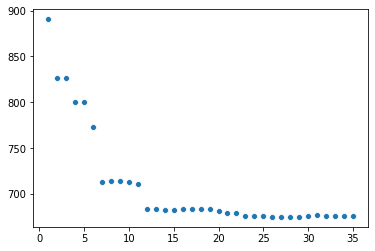

In [0]:
import seaborn as sns

sns.scatterplot(range(1, X_train_eng.shape[1]+1), mae_list)

## Challenge

In your assignment, you will do feature selection with SelectKBest.

You'll go back to our other New York City real estate dataset. Instead of predicting apartment rents, you'll predict property sales prices. But not just for condos in Tribeca. Instead, you'll predict property sales prices for One Family Dwellings, where the sale price was more than 100 thousand and less than 2 million.

If you run the above code cell with your assignment dataset, you will probably get some shocking results like these:

```
1 features
Test MAE: $183,641 

2 features
Test MAE: $182,569 

3 features
Test MAE: $182,569 

4 features
Test MAE: $183,441 

5 features
Test MAE: $186,532 

6 features
Test MAE: $176,121 

7 features
Test MAE: $177,001 

8 features
Test MAE: $176,707 

9 features
Test MAE: $170,969 

10 features
Test MAE: $170,977 

11 features
Test MAE: $170,507 

12 features
Test MAE: $162,301 

13 features
Test MAE: $163,559 

14 features
Test MAE: $162,562 

15 features
Test MAE: $162,550 

16 features
Test MAE: $162,678 

17 features
Test MAE: $162,419 

18 features
Test MAE: $162,177 

19 features
Test MAE: $162,177 

20 features
Test MAE: $157,893 

21 features
Test MAE: $157,966 

22 features
Test MAE: $157,966 

23 features
Test MAE: $157,966 

24 features
Test MAE: $157,630 

25 features
Test MAE: $157,580 

26 features
Test MAE: $25,968,990,575,776,280 

27 features
Test MAE: $157,550 

28 features
Test MAE: $87,300,193,986,380,608 

29 features
Test MAE: $158,491 

30 features
Test MAE: $17,529,140,644,990,770 

31 features
Test MAE: $24,191,458,933,688,856 

32 features
Test MAE: $15,214,122,471,992,104 

33 features
Test MAE: $15,539,731,847,001,626 

34 features
Test MAE: $26,823,915,969,200,480 

35 features
Test MAE: $3,813,290,272,870,121 

36 features
Test MAE: $157,900 

37 features
Test MAE: $157,900 

38 features
Test MAE: $158,911 

39 features
Test MAE: $9,101,846,282,581,472 

40 features
Test MAE: $1,424,168,120,777,820 

41 features
Test MAE: $158,261 

42 features
Test MAE: $158,261 

43 features
Test MAE: $4,784,333,158,313,152 

44 features
Test MAE: $1,329,759,264,341,476 

45 features
Test MAE: $158,451 

46 features
Test MAE: $158,450 

47 features
Test MAE: $158,450 

48 features
Test MAE: $1,331,383,815,682,658 

49 features
Test MAE: $1,504,319,420,789,134 

50 features
Test MAE: $2,285,927,437,866,492
```

Why did the error blow up with 26 features? We can look at the coefficients of the selected features:

```
BLOCK                                                  -97,035
ZIP_CODE                                              -152,985
COMMERCIAL_UNITS                    -4,115,324,664,197,034,496
TOTAL_UNITS                         -2,872,516,607,892,124,160
GROSS_SQUARE_FEET                                      123,739
BOROUGH_3                                              146,876
BOROUGH_4                                              197,262
BOROUGH_2                                              -55,917
BOROUGH_5                                              -84,107
NEIGHBORHOOD_OTHER                                      56,036
NEIGHBORHOOD_FLUSHING-NORTH                             63,394
NEIGHBORHOOD_FOREST HILLS                               46,411
NEIGHBORHOOD_BOROUGH PARK                               29,915
TAX_CLASS_AT_PRESENT_1D               -545,831,543,721,722,112
BUILDING_CLASS_AT_PRESENT_A5                            -1,673
BUILDING_CLASS_AT_PRESENT_A3             5,516,361,218,128,626
BUILDING_CLASS_AT_PRESENT_S1         1,735,885,668,110,473,216
BUILDING_CLASS_AT_PRESENT_A6           -25,974,113,243,185,788
BUILDING_CLASS_AT_PRESENT_A8          -760,608,646,332,801,664
BUILDING_CLASS_AT_PRESENT_S0           941,854,072,479,442,176
BUILDING_CLASS_AT_TIME_OF_SALE_A5                      -24,599
BUILDING_CLASS_AT_TIME_OF_SALE_A3       -5,516,361,218,111,506
BUILDING_CLASS_AT_TIME_OF_SALE_S1    4,253,055,231,847,939,072
BUILDING_CLASS_AT_TIME_OF_SALE_A6       25,974,113,243,176,404
BUILDING_CLASS_AT_TIME_OF_SALE_A8     -541,733,439,448,260,800
BUILDING_CLASS_AT_TIME_OF_SALE_S0      990,851,394,820,416,512
```

These were the coefficients that minimized the sum of squared errors in the training set. But this model has become too complex, with extreme coefficients that can lead to extreme predictions on new unseen data. 

This linear model needs _regularization._ Ridge Regression to the rescue!

# Use scikit-learn to fit Ridge Regression models

## Overview

Josh Starmer explains in his [StatQuest video on Ridge Regression:](https://youtu.be/Q81RR3yKn30?t=222)

> The main idea behind **Ridge Regression** is to find a new line that _doesn't_ fit the training data as well. In other words, we introduce a small amount of **bias** into how the new line is fit to the data. But in return for that small amount of bias we get a significant drop in **variance.** In other words, by starting with a slightly worse fit Ridge regression can provide better long-term predictions. BAM!!!

### OLS vs Mean Baseline vs Ridge

Let's see look at some examples.

First, here's a famous, tiny dataset — [Anscombe's quartet](https://en.wikipedia.org/wiki/Anscombe%27s_quartet), dataset III:

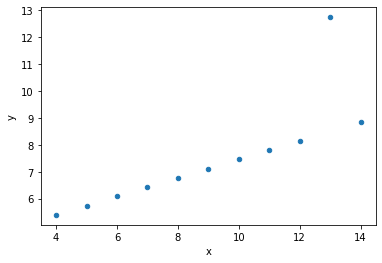

In [0]:
import seaborn as sns
anscombe = sns.load_dataset('anscombe').query('dataset=="III"')
anscombe.plot.scatter('x', 'y');

We'll compare:
- Ordinary Least Squares Linear Regression
- Mean Baseline
- Ridge Regression

#### OLS

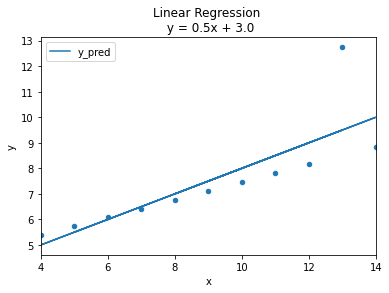

In [0]:
%matplotlib inline

# Plot data
ax = anscombe.plot.scatter('x', 'y')

# Fit linear model
ols = LinearRegression()
ols.fit(anscombe[['x']], anscombe['y'])

# Get linear equation
m = ols.coef_[0].round(2)
b = ols.intercept_.round(2)
title = f'Linear Regression \n y = {m}x + {b}'

# Get predictions
anscombe['y_pred'] = ols.predict(anscombe[['x']])

# Plot predictions
anscombe.plot('x', 'y_pred', ax=ax, title=title);

#### Mean Baseline

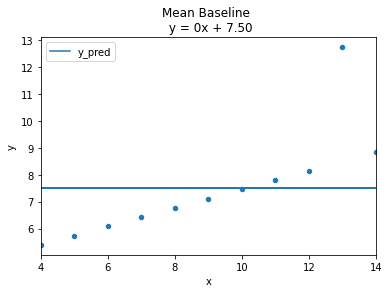

In [0]:
# Plot data
ax = anscombe.plot.scatter('x', 'y')

# Mean baseline
mean = anscombe['y'].mean()
anscombe['y_pred'] = mean
title = f'Mean Baseline \n y = 0x + {mean:.2f}'

# Plot "predictions"
anscombe.plot('x', 'y_pred', ax=ax, title=title);

#### Ridge Regression

With increasing regularization:

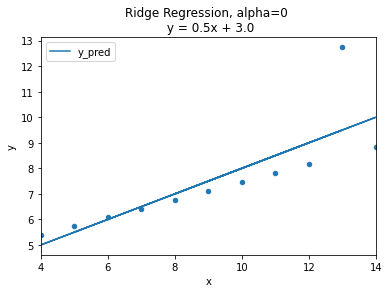

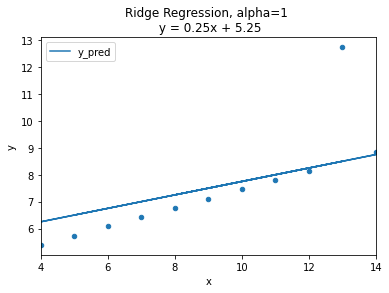

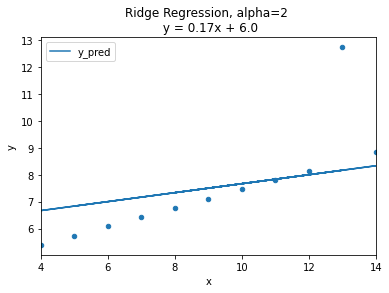

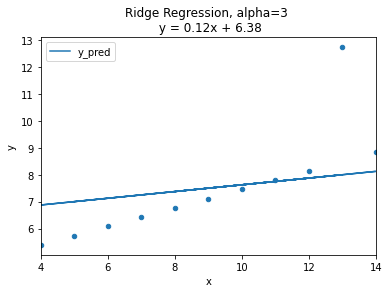

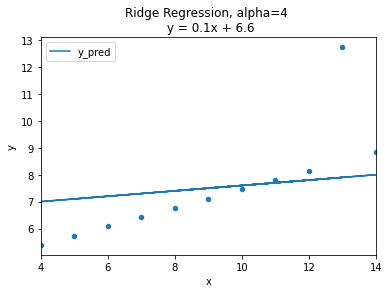

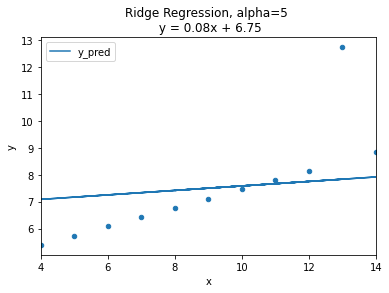

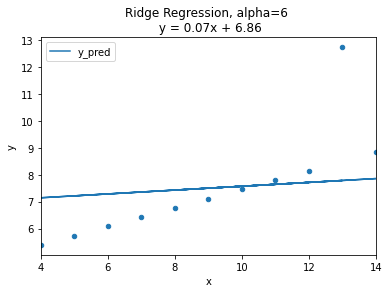

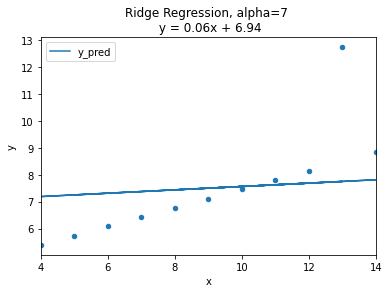

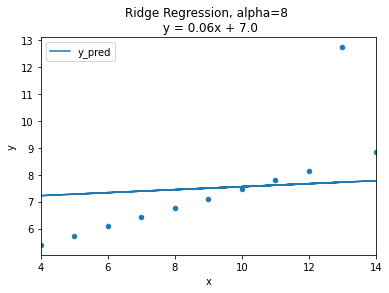

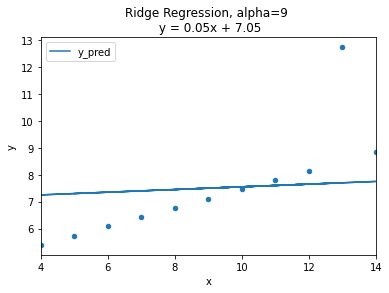

In [0]:
import matplotlib.pyplot as plt
from sklearn.linear_model import Ridge

def ridge_anscombe(alpha):
    """
    Fit & plot a ridge regression model,
    with Anscombe Quartet dataset III.

    alpha : positive float, regularization strength
    """

    # Load data
    anscombe = sns.load_dataset('anscombe').query('dataset=="III"')

    # Plot data
    ax = anscombe.plot.scatter('x', 'y')

    # Fit linear model
    ridge = Ridge(alpha=alpha, normalize=True)
    ridge.fit(anscombe[['x']], anscombe['y'])

    # Get linear equation
    m = ridge.coef_[0].round(2)
    b = ridge.intercept_.round(2)
    title = f'Ridge Regression, alpha={alpha} \n y = {m}x + {b}'

    # Get predictions
    anscombe['y_pred'] = ridge.predict(anscombe[['x']])

    # Plot predictions
    anscombe.plot('x', 'y_pred', ax=ax, title=title)
    plt.show()
    
    
for alpha in range(10):
    ridge_anscombe(alpha=alpha)

When the Ridge Regression has no regularization (`alpha=0`) then it is identical to Ordinary Least Squares Regression.

When we increase the regularization, the predictions looks less and less like OLS and more and more like the mean baseline. The predictions are less sensitive to changes in the independent variable.

You may ask, how should we decide the amount of regularization?

[The StatQuest video answers,](https://youtu.be/Q81RR3yKn30?t=602)

> So how do we decide what value to give lambda? We just try a bunch of values for lambda, and use cross-validation
typically 10-fold cross-validation, to determine which one results in the lowest variance. DOUBLE BAM!!!

You'll learn more about cross-validation next sprint. For now, the good news is scikit-learn gives us [RidgeCV](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.RidgeCV.html), "Ridge regression with built-in cross-validation."

Also, notice that scikit-learn calls the regularization parameter "alpha", but StatQuest calls it "lambda." The greek letters are different, but the concept is the same.

Let's try these values for alpha:

In [0]:
alphas = [0.01, 0.1, 1.0, 10.0, 100.0]

We'll use [RidgeCV](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.RidgeCV.html) to find the best alpha:

In [0]:
from sklearn.linear_model import RidgeCV
ridge = RidgeCV(alphas=alphas, normalize=True)
ridge.fit(anscombe[['x']], anscombe['y'])
ridge.alpha_

0.1

The fit looks similar to Ordinary Least Squares Regression, but slightly less influenced by the outlier:

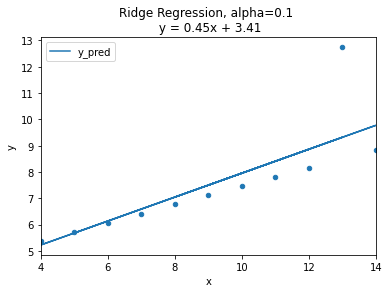

In [0]:
# Plot data
ax = anscombe.plot.scatter('x', 'y')

# Get linear equation
m = ridge.coef_[0].round(2)
b = ridge.intercept_.round(2)
title = f'Ridge Regression, alpha={ridge.alpha_} \n y = {m}x + {b}'

# Get predictions
anscombe['y_pred'] = ridge.predict(anscombe[['x']])

# Plot predictions
anscombe.plot('x', 'y_pred', ax=ax, title=title)
plt.show()

### NYC, 1 feature

Let's go back to our other New York City dataset, to demonstrate regularization with Ridge Regresson:

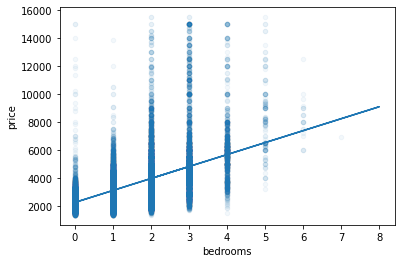

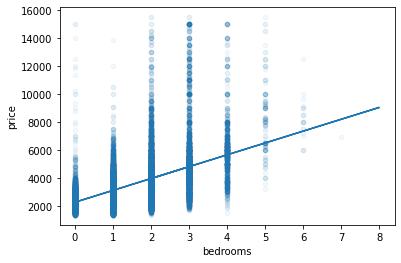

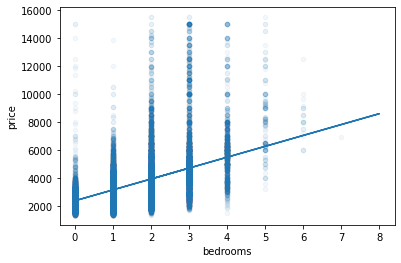

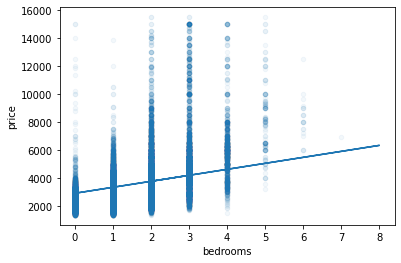

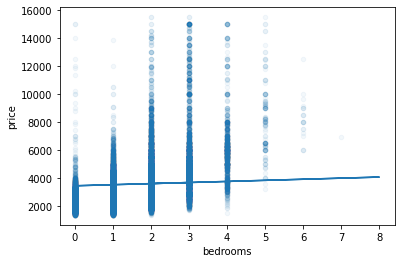

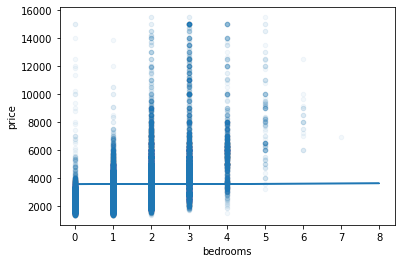

In [0]:
from IPython.display import display, HTML

# Try a range of alpha parameters for Ridge Regression.

# The scikit-learn docs explain, 
# alpha : Regularization strength; must be a positive float. Regularization 
# improves the conditioning of the problem and reduces the variance of the 
# estimates. Larger values specify stronger regularization.
# https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.Ridge.html

for alpha in [0.001, 0.01, 0.1, 1.0, 10.0, 100.0]:
    
    # Fit Ridge Regression model
    feature = 'bedrooms'
    display(HTML(f'Ridge Regression, with alpha={alpha}'))
    model = Ridge(alpha=alpha, normalize=True)
    model.fit(X_train[[feature]], y_train)
    
    # Get Test MAE
    y_pred = model.predict(X_test[[feature]])
    mae = mean_absolute_error(y_test, y_pred)
    display(HTML(f'Test Mean Absolute Error: ${mae:,.0f}'))
    
    train.plot.scatter(feature, target, alpha=0.05)
    plt.plot(X_test[feature], y_pred)
    plt.show()

### NYC, multiple features

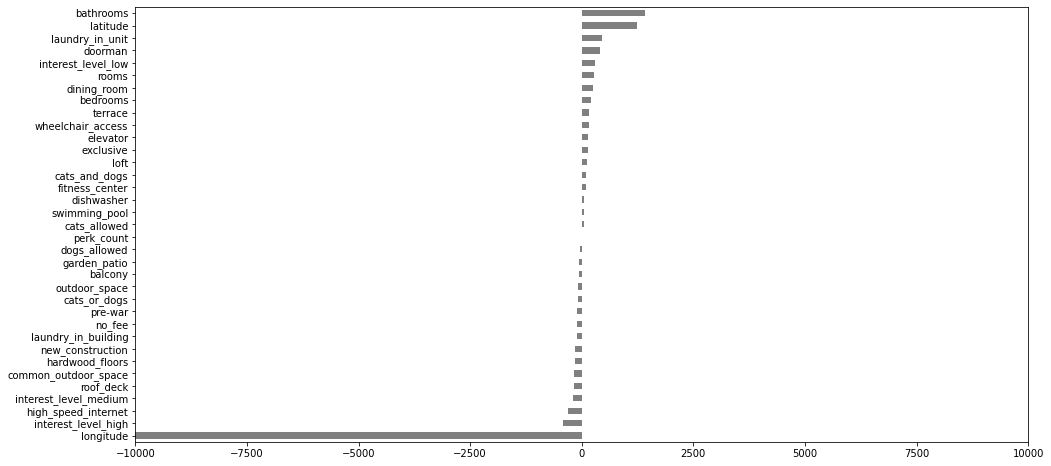

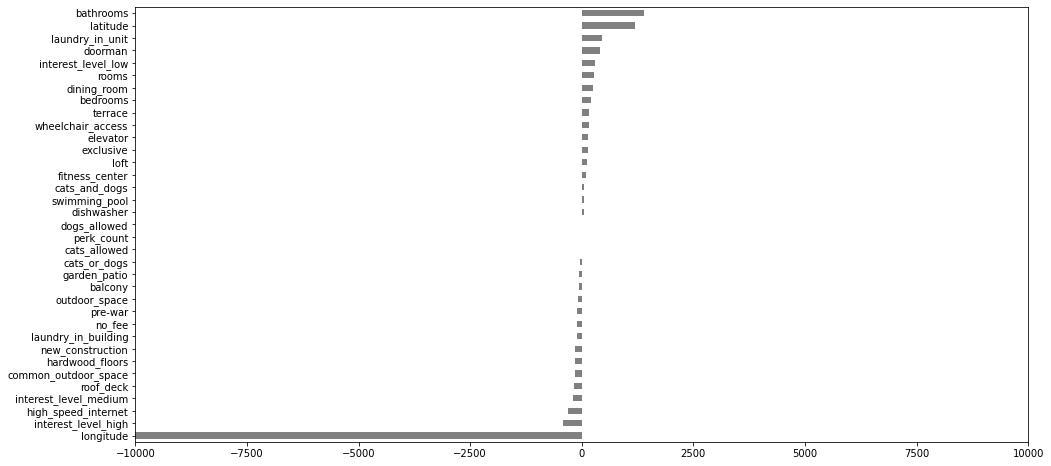

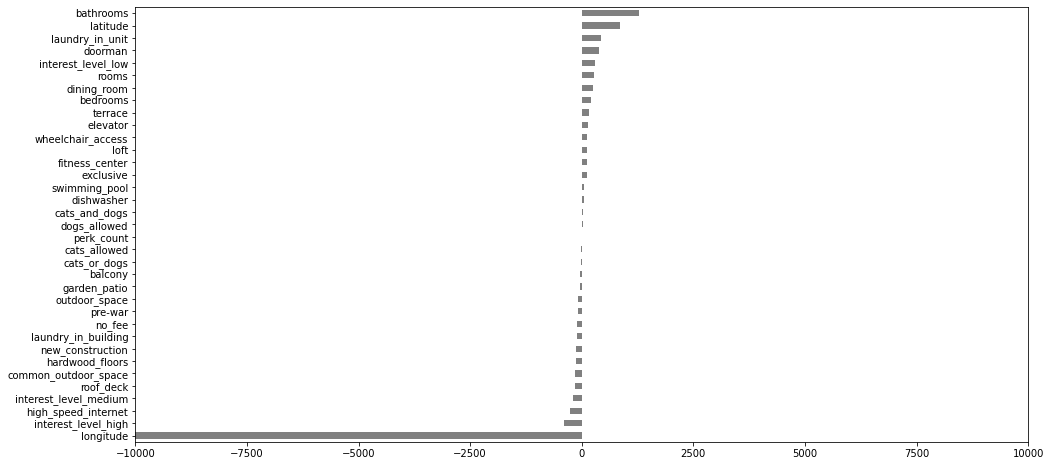

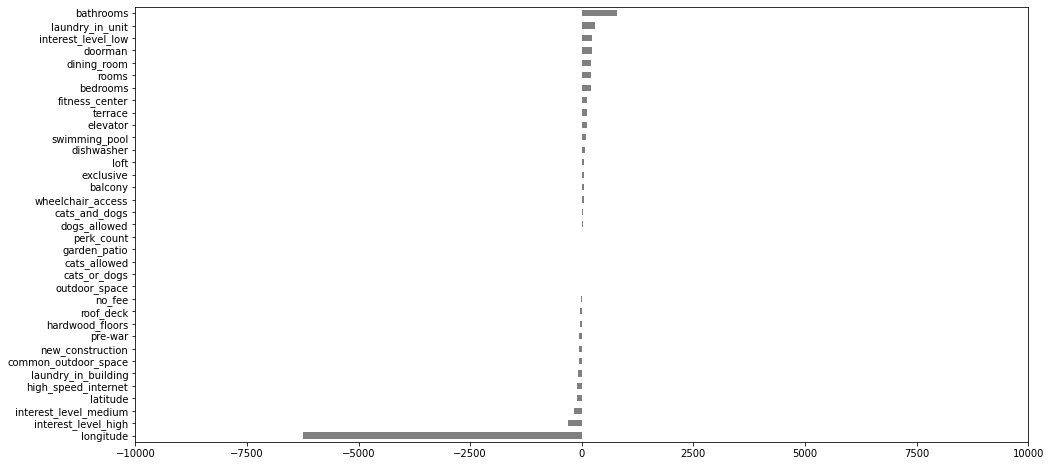

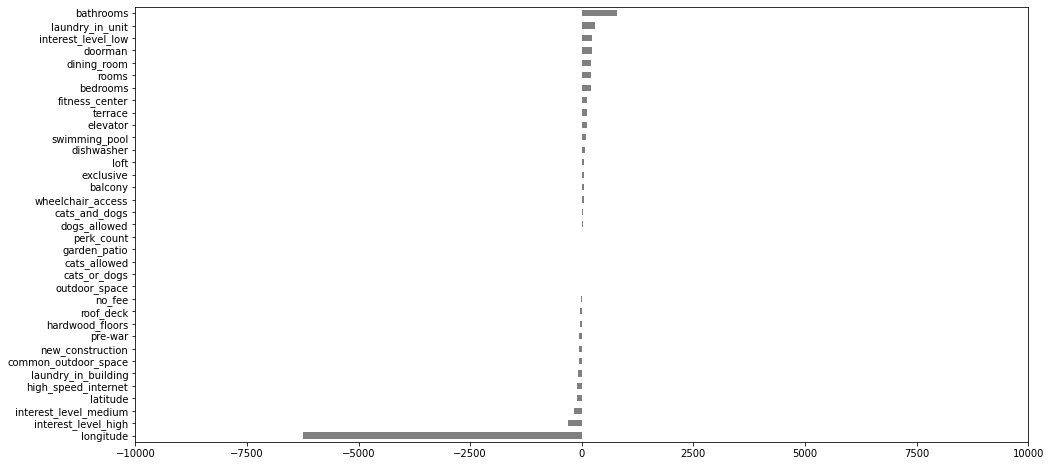

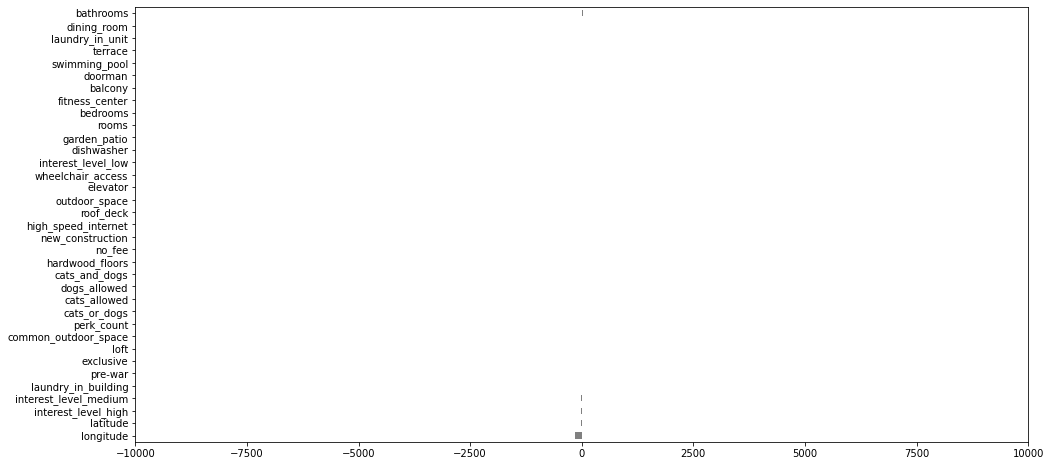

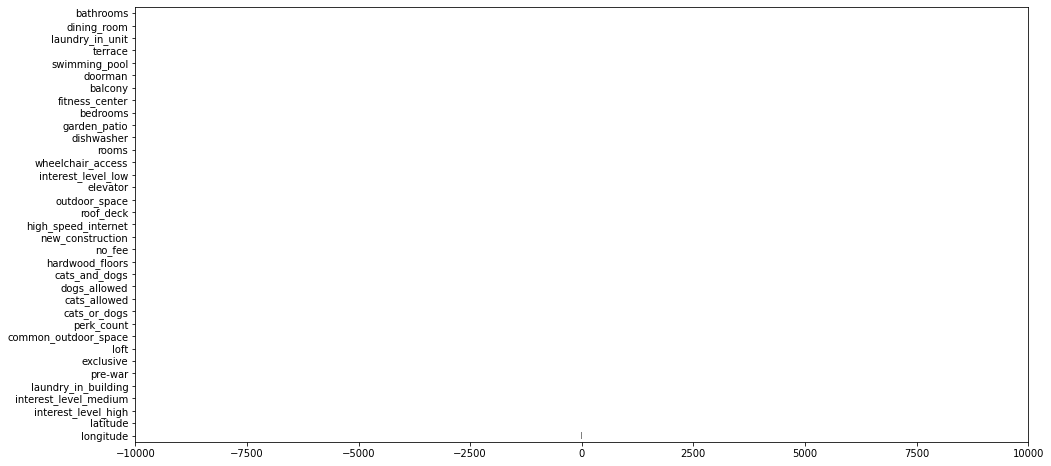

In [0]:
for alpha in [0.001, 0.01, 0.1, 1.0, 1, 100.0, 1000.0]:
    
    # Fit Ridge Regression model
    display(HTML(f'Ridge Regression, with alpha={alpha}'))
    model = Ridge(alpha=alpha, normalize=True)
    model.fit(X_train_eng, y_train)
    y_pred = model.predict(X_test_eng)

    # Get Test MAE
    mae = mean_absolute_error(y_test, y_pred)
    display(HTML(f'Test Mean Absolute Error: ${mae:,.0f}'))
    
    # Plot coefficients
    coefficients = pd.Series(model.coef_, X_train_eng.columns)
    plt.figure(figsize=(16,8))
    coefficients.sort_values().plot.barh(color='grey')
    plt.xlim(-10000,10000)
    plt.show()

### Regularization just means "add bias"

OK, there's a bit more to it than that. But that's the core intuition - the problem is the model working "too well", so fix it by making it harder for the model!

It may sound strange - a technique that is purposefully "worse" - but in certain situations, it can really get results.

What's bias? In the context of statistics and machine learning, bias is when a predictive model fails to identify relationships between features and the output. In a word, bias is *underfitting*.

We want to add bias to the model because of the [bias-variance tradeoff](https://en.wikipedia.org/wiki/Bias%E2%80%93variance_tradeoff) - variance is the sensitivity of a model to the random noise in its training data (i.e. *overfitting*), and bias and variance are naturally (inversely) related. Increasing one will always decrease the other, with regards to the overall generalization error (predictive accuracy on unseen data).

Visually, the result looks like this:

![Regularization example plot](https://upload.wikimedia.org/wikipedia/commons/0/02/Regularization.svg)

The blue line is overfit, using more dimensions than are needed to explain the data and so much of the movement is based on noise and won't generalize well. The green line still fits the data, but is less susceptible to the noise - depending on how exactly we parameterize "noise" we may throw out actual correlation, but if we balance it right we keep that signal and greatly improve generalizability.

## Challenge

In your assignment, you will fit a Ridge Regression model. You can try Linear Regression too — depending on how many features you select, your errors will probably blow up!

# Review

For your assignment, we're going back to our other **New York City** real estate dataset. Instead of predicting apartment rents, you'll predict property sales prices.

But not just for condos in Tribeca...

Instead, predict property sales prices for **One Family Dwellings** (`BUILDING_CLASS_CATEGORY` == `'01 ONE FAMILY DWELLINGS'`). 

Use a subset of the data where the **sale price was more than \\$100 thousand and less than $2 million.** 

You'll practice all of the module's objectives to build your best model yet!